# Configuración del Generador HP33120A de 15MHz como fuente arbitraria. Desarrollo de la biblioteca de comunicación serial con mediador USB2GPIB.

**Autores:** Prof. Andrés Roldán Aranda, Juan del Pino Mena.

# Changelog

- **V02 - 31/01/2022 - Juan del Pino Mena** - WIP
    - [x] Añadido indicaciones para el puerto en Linux.
    - [x] Estandarizado el estilo del código: Docuementación y comentarios, sangrado, espaciado, etc.
    - [x] Organización del código para la comunicación en dos clases: 
        - USB2GPIB Contiene funciones de comunicación con el mediador, usando comandos "++".
        - HP33120A Contiene funciones de gestión con el generador (esclavo). Comandos del estándar SCPI (Standard Commands for Programmable Instruments) enviados a través de USB al mediador, y de este al esclavo (el generador) por GPIB (HP-IB) IEEE-488.2.
    - [ ] Implementación del setup y envío de muestras para señales arbitrarias
    - [x] Implementación de comandos para sincronizar por trigger ambos generadores
    - [ ] Redacción de las clases en archivos .py para poder ser importado como una biblioteca por scripts y notebooks.
    
- **V01 - 30/09/2021 - Prof. Andrés Roldán Aranda**
    - Implementación inicial

# Referencias 

- Emanuele Girlando. ARDUINO UNO as a USB to GPIB controller:
    - Versión 2 (6.1) 
        https://egirland.blogspot.com/2014/03/arduino-uno-as-usb-to-gpib-controller.html
    - Versión 1, con referencia de cada comando "++" 
        https://egirland.blogspot.com/2014/02/arduino-uno-as-usb-to-gpib-adapter.html      
- Manual "HP 33120A Function Generator / Arbitrary Waveform Generator".

# Configuración del puerto

## En Windows

En Windows pulsamos Windows+X y se nos abre la ventana de ejecución y le damos al *Administrador de Dispositivos** y vemos el puerto serie del *Arduino Uno* que realiza la transformación de comandos **RS232** a **GPIB**.

Parece que hay otro modelo más avanzado pero necesita una PCB y un microcontrolador potente ARM7. Ver [WEB](https://github.com/xyphro/UsbGpib)

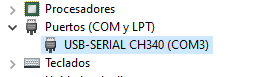

## En Linux

En linux, los dispositivos serie por USB aparecen listados en `/dev/ttyUSB*`. No es necesario instalar ningún driver. Lo más usual es que sea simplemente `/dev/ttyUSB0` independientemente del USB al que se conecte. En caso de haber más dispositivos serial conectados, podemos identificarlos rápidamente con: 

- `lsusb` lista los dispositivos USB conectados al PC. Aparecen identificados por un ID (en el caso del CH340: 1a86:7523).
- `ls /dev/USB*` muestra todos los dispositivos serial USB. En la captura sólo hay uno: el `/dev/ttyUSB0`.
- `grep PRODUCT= /sys/bus/usb-serial/devices/ttyUSB0/../uevent` nos permite comprobar qué ttyUSB corresponde a qué dispositivo USB, identificado por su ID. Confirmamos que el ID del USB0 es el ID del CH340.


(fuente: https://unix.stackexchange.com/questions/81754/how-to-match-a-ttyusbx-device-to-a-usb-serial-device)

![linux.png](images/linux_tty.png)


# Manual del dispositivo

In [1]:
from IPython.display import IFrame, display
IFrame("./docs/user_manual_HP33120A.pdf", width=1000, height=700)

# Pruebas en línea de comandos

Ajeno a la biblioteca, son una colección de funciones y pruebas, que ayudan a entender el comportamiento de los dispositivos, en específico del mediador. Ver biblioteca más abajo.

In [ ]:
import serial
import time

# USAR EL PUERTO EN FUNCIÓN DEL S.O.:

# port_USB2GPIB = 'COM3'  # En Windows = COMX, siendo X={1, 2, ...}
port_USB2GPIB = '/dev/ttyUSB0'  # En Linux: /dev/ttyUSBX, siendo X = {0, 1, ...}
timeout = 0.5  # Timeout global, segundos

s = serial.Serial(port_USB2GPIB,        # Puerto
                  115200,               # Baudios  
                  serial.EIGHTBITS,     # Payload de 8 bits
                  serial.PARITY_NONE,   # Sin paridad
                  serial.STOPBITS_ONE,  # 1 bit de parada
                  timeout=timeout,      # tiempo de dropout
                  rtscts=False)         # Señales RTS->CTS

In [2]:
s.reset_input_buffer()
s.write(b'++ver' + b'\n')

6

In [3]:
bytes_Available=s.in_waiting
print("Bytes disponibles=" + str(bytes_Available))

Bytes disponibles=50


In [4]:
out=s.read(100)
type(out)

bytes

In [5]:
print("Leído=" + str(out))

Leído=b'ARDUINO GPIB firmware by E. Girlando Version 6.1\r\n'


In [6]:
out.split()

[b'ARDUINO',
 b'GPIB',
 b'firmware',
 b'by',
 b'E.',
 b'Girlando',
 b'Version',
 b'6.1']

In [7]:
ID_Mediator=out.split()[2]
print("Identify = " + str(ID_Mediator))

Identify = b'firmware'


Discrepancia con el archivo original: la salida anterior era `Identify = b'"BK2238"'`, pero el string de `out` es el que es, se ha identificado correctamente. ¿Qué ocurre? ¿Es importante el `BK2238`?

NOTA: No, era de otro equipo mediador. No es relevante


---


Nota (Juan): Redactado comentarios, arreglado el estilo de sangrado, añadido parámetros opcionales.
Cambiado el tipo de verbose de int a bool y hecho parámetro opcional, para dar consistencia.
Implementar en una clase?

In [9]:
length_string_read = 100  # Cte: longitud de caracteres a leer del buffer.

def Identify_USB2GPIB(verbose=True):   # Prof. Andrés Roldán
    """ 
    Envío de comando para que identificar al intermediario
    Read ++ver
    """
    
    s.reset_input_buffer()
    s.write(b'++ver' + b'\r\n')
    out = s.read(length_string_read)
    
    if verbose:
        print("Leído=" + str(out))
    return(out)


def USB2GPIB_AutoResponse_Set(auto_mode=0, verbose=True):   # Prof. Andrés Roldán
    """ 
    Envío de comando para establecer la respuesta automática del mediador y no 
    tener que hacer un ++read por cada comando enviado.
    Send ++auto <param>, por defecto auto_mode=0 (0: automático, 1: no automático) 
    """
    
    #Enviamos comando para que se identifique
    s.reset_input_buffer()
    command_query = f'++auto {auto_mode} '
    s.write(command_query.encode() + b'\r\n')
    
    if verbose:
        print("Enviado " + "++auto " + str(auto_mode))
       
    
def USB2GPIB_AutoResponse_Get(verbose=True):   # Prof. Andrés Roldán
    """ 
    Pregunta al mediador por su estado de AutoResponse.
    Send ++auto
    """
    
    s.reset_input_buffer()
    command_query = '++auto'
    s.write(command_query.encode() + b'\r\n')
    out = s.read(length_string_read)
    
    if verbose:
        print("Leído=" + str(out))
    return(out)            
            
    
def USB2GPIB_Slave_Address_Set(address, verbose=True):   # Prof. Andrés Roldán
    """ 
    Establece la dirección del esclavo.
    Send ++addr Address
    """
    
    s.reset_input_buffer()
    command_query = '++addr '
    s.write(command_query.encode() + (str(address)).encode() + b'\r\n')
    
    if verbose:
        print("Enviado " + "++addr " + str(address))

        
def USB2GPIB_Slave_Address_Get(verbose=True):   # Prof. Andrés Roldán
    """ 
    
    Send ++addr 
    """
    
    s.reset_input_buffer()
    command_query = '++addr'
    s.write(command_query.encode() + b'\r\n')
    out = s.read(length_string_read)
    
    if verbose:
        print("Leído=" + str(out))
    return(out)

In [10]:
# Identificamos al mediador
Identify_USB2GPIB()

Leído=b'ARDUINO GPIB firmware by E. Girlando Version 6.1\r\n'


b'ARDUINO GPIB firmware by E. Girlando Version 6.1\r\n'

In [11]:
# Configuramos el modo de no pregunta automático "++AUTO 0"
USB2GPIB_AutoResponse_Set(auto_mode=0)

Enviado ++auto 0


In [12]:
# Preguntamos por la configuración del modo de pregunta automático "++AUTO"
USB2GPIB_AutoResponse_Get()

Leído=b'0\r\n'


b'0\r\n'

In [13]:
# Configuramos la dirección del SLAVE GPIB a 10 en byte pero cada caracter.
Generator_HP33120A_Address = 10  # Dirección del equipo. Aparece al encerder la fuente.
USB2GPIB_Slave_Address_Set(Generator_HP33120A_Address, verbose=True)

Enviado ++addr 10


In [27]:
# Leemos la dirección del SLAVE GPIB
USB2GPIB_Slave_Address_Get(verbose=False)

b'10\r\n'

# Clase para manejar el generador. Implementación de la biblioteca


In [3]:
# Repetimos estas sentencias del inicio para tener la configuración a mano

import serial
import time

# port_USB2GPIB = 'COM3'  # En Windows = COMX, siendo X={1, 2, ...}
port_USB2GPIB = '/dev/ttyUSB1'  # En Linux: /dev/ttyUSBX, siendo X = {0, 1, ...}
timeout = 0.5  # Timeout global, segundos

s = serial.Serial(port_USB2GPIB,        # Puerto
                  115200,               # Baudios  
                  serial.EIGHTBITS,     # Payload de 8 bits
                  serial.PARITY_NONE,   # Sin paridad
                  serial.STOPBITS_ONE,  # 1 bit de parada
                  timeout=timeout,      # tiempo de dropout
                  rtscts=False)         # Señales RTS->CTS

## USB2GPIB: Comandos para el mediador

Sencilla clase que contiene funciones de configuración para el mediador. Uso de comandos "++". No están implementados todos los comandos disponibles, tan sólo los principales para poder acceder al esclavo GPIB.

In [4]:
class USB2GPIB:
    """
    Colección de métodos para comunicarse con el mediador USB2GPIB. Arduino con 
    firmware "Arduino UNO as a USB to GPIB adapter / controller" v6.1 de 
    Emanuele Girlando.
    
    Implementación inicial por Andrés Roldán Aranda (v01, 30/09/2021) 
    Reescrito y expandido por Juan del Pino Mena (v02, 31/01/2022)
    """
    
    def __init__(self, length_string_read=100):
        """
        Constructor.
        :param length_string_read: longitud de caracteres a leer del buffer. Por
            defecto 100.
        :type length_string_read int 
        """
        self.length_string_read = length_string_read
    
    def _send(self, cmd, verbose=True):
        """
        Envío de mensajes al mediador. Resetea el buffer en cada llamada.
        :param cmd: comando a enviar
        :type cmd str
        """
        s.reset_input_buffer()  # reset del buffer
        s.write(cmd.encode() + b'\r\n')  # comando + caracteres de parada, bytes
        if verbose:
            print(f"Sent: {cmd}")
        
    def _read(self, verbose=True):
        """
        Recepción de mensajes del mediador.
        :returns out: mensaje captado.
        :type out str
        """
        out = s.read(self.length_string_read)  # lee del buffer serial
        if verbose:
            print(f"Read: {str(out)}")
        return out
    
    def identify(self, verbose=True):
        """ 
        Identificar al intermediario
        Read ++ver
        """
        cmd = "++ver"
        self._send(cmd, verbose)
        return self._read(verbose)

    def set_auto_response(self, auto_mode=0, verbose=True):
        """ 
        Envío de comando para establecer la respuesta automática del mediador y
        no tener que hacer un ++read por cada comando enviado.
        Send ++auto <auto_mode>
        :param mode: parámetro para el comando, por defecto auto_mode=0
        """
        cmd = f"++auto {auto_mode}"
        self._send(cmd, verbose)
       
    def get_auto_response(self, verbose=True):
        """ 
        Pregunta al mediador por su estado de AutoResponse.
        Send ++auto
        """
        cmd = "++auto"
        self._send(cmd, verbose)
        return self._read(verbose)      
            
    def set_slave_address(self, address, verbose=True):
        """ 
        Establece la dirección del esclavo (el generador de señal).
        Send ++addr Address
        :param address: dirección del equipo esclavo a comunicar por GPIB.
        """
        cmd = f"++addr {str(address)}"
        self._send(cmd, verbose)

    def get_slave_address(self, verbose=True):
        """ 
        Consulta la dirección del esclavo
        Send ++addr 
        """
        cmd = "++addr"
        self._send(cmd, verbose)
        return self._read(verbose)

### Ejemplo de uso

Inicializamos la clase. Identificamos al dispositivo y establecemos el tipo de respuesta, así como la dirección del esclavo al que queremos enviar órdenes.

In [5]:
Mediador = USB2GPIB()
Mediador.identify()

Mediador.set_auto_response(auto_mode=0)
Mediador.set_slave_address(address=10)

Mediador.get_auto_response()
Mediador.get_slave_address()

Sent: ++ver
Read: b'ARDUINO GPIB firmware by E. Girlando Version 6.1\r\n'
Sent: ++auto 0
Sent: ++addr 10
Sent: ++auto
Read: b'0\r\n'
Sent: ++addr
Read: b'10\r\n'


b'10\r\n'

## HP33120A: Comandos para la fuente de señal.

Contiene funciones para configurar el generador HP33120A a través del mediador. No contiene todos los comandos posibles del dispositivo, sino que está enfocada al envío de muestras para generar una señal arbitraria.

In [143]:
import time

In [1]:
class HP33120A:
    """
    Funciones del generador HP33120A
    
    Implementación inicial por Andrés Roldán Aranda (v01, 30/09/2021) 
    Reescrito y expandido por Juan del Pino Mena (v02, 31/01/2022)
    
    NOTA: Los métodos de esta clase esperan que la comunicación se realize por
    serial, siendo necesario un intermediario tipo USB 2 GPIB.
    Para comunicarse con cada equipo conectado se debe especificar primero la 
    dirección correspondiente al mediador.
    """
    
    def __init__(self, length_string_read=100):
        """
        Constructor.
        :param length_string_read: longitud de caracteres a leer del buffer. Por
            defecto 100.
            
        Este parámetro afecta a los comandos demasiado extensos como por ejemplo
        el envío de muestras de señal.
        :type length_string_read int
        """
        self.length_string_read = length_string_read
    
    def _send(self, cmd, verbose=True):
        """
        Envío de mensajes al mediador. Resetea el buffer en cada llamada.
        :param cmd: comando a enviar
        :type cmd str
        """
        s.reset_input_buffer()  # reset del buffer
        s.write(cmd.encode() + b'\r\n')  # comando + caracteres de parada, en bytes
        if verbose:
            print(f"Sent: {cmd}")
        
    def _read(self, verbose=True):
        """
        Recepción de mensajes del mediador.
        :returns out: mensaje captado.
        :type out str
        """
        s.write(b'++read\r\n')
        out = s.read(self.length_string_read)  # lee del buffer serial
        if verbose:
            print(f"Read: {str(out)}")
        return out
    
    # SYSTEM COMMANDS
    # Funciones del sistema. Gestión, consultas, reset.
    
    def reset(self, verbose=True):
        """ 
        Comando de Reset al generador de señal.
        Send *RST 
        Página 190 del manual
        """
        cmd = "*RST"
        self._send(cmd, verbose)
    
    def identify(self, verbose=True):
        """
        Identificación del generador
        Send *IDN?
        Página 190 del manual
        """
        cmd = "*IDN?"
        self._send(cmd, verbose)
        return self._read()

    def version(self, verbose=True):
        """
        Versión del generador
        Send SYSTem:VERSion?  
        Página 190 del manual
        """
        cmd = "SYSTem:VERSion?"
        self._send(cmd, verbose)
        return self._read()
    
    def error(self, verbose=True):
        """
        Leer de la pila de errores. Es una pila FIFO.
        Send SYSTem:ERRor?
        Página 110 del manual
        """
        cmd = "SYSTem:ERRor?"
        self._send(cmd, verbose)
        return self._read()
    
    # OUTPUT WAVEFORM COMMANDS
    # Funciones para variar las condiciones de salida: amplitud, frecuencia, 
    # offset y carga.
    
    def set_amplitude(self, vpp, verbose=True):
        """
        Voltaje pico-pico de la señal (el doble de la amplitud). Se debe 
        ajustar el valor de la carga a la salida para tener el valor deseado.
        Send VOLT <vpp>
        Página 148 del manual
        """
        cmd = f"VOLT {vpp}"
        self._send(cmd, verbose)
    
    def set_frequency(self, freq, verbose=True):
        """
        Frecuencia de la señal. En señales arbitrarias NO es la frecuencia de 
        muestreo sino la de repetición de la señal completa.
        Úsese la función adjunta para 
        Send FREQ <freq>
        Página 146 del manual.
        """
        cmd = f"FREQ {freq}"
        self._send(cmd, verbose)
    
    def set_offset(self, offset, verbose=True):
        """
        Send VOLT:OFFS
        Página 149 del manual
        """
        cmd = f"VOLT:OFFS {offset}"
        self._send(cmd, verbose)
        
    def set_output_load(self, load, verbose=True):
        """
        Send OUTP:LOAD <load>
        Opciones de load:
        {50|INF}
        """
        cmd = f"OUTP:LOAD {load}"
        self._send(cmd, verbose)
    
    def set_output_waveform(self, func, verbose=True):
        """
        Send FUNC:SHAP <func>
        Página 145 del manual
        SIN, SQU, TRI, RAMP, NOIS, DC
        """
        cmd = f"FUNC:SHAP {func}"
        self._send(cmd, verbose)
    
    def get_output_waveform(self, verbose=True):
        """
        Send FUNC:SHAP?
        """
        cmd = f"FUNC:SHAP?"
        self._send(cmd, verbose)
        return self._read(verbose)
    
    def get_output_parameters(self, verbose=True):
        """
        Send APPLy?
        """
        cmd = "APPLy?"
        self._send(cmd, verbose)
        return self._read(verbose)
    
    # BURST COMMANDS
    # Para generar dos funciones sincronizadas el trigger no es necesario, sino
    # usar una modulación de ráfaga
    
    def enable_burst(self, mode : str, verbose=True):
        """
        Send BM:STATe {OFF|ON}
        
        Página 84 del manual
        Set up other modulation after setting other burst modulation
        """
        cmd = f"BM:STATe {mode}"
        self._send(cmd, verbose)
        
    def set_burst_count(self, count : int, verbose=True):
        """
        Send BM:NCYC
        
        Página 81 del manual
        """
        cmd = f"BM:NCYC {count}"
    
    # TRIGGER COMMANDS
    
    def set_trigger_source(self, mode : str, verbose=True):
        """
        Send TRIGger:SOURce <EXTernal|IMMediate|BUS>
        """
        cmd = f"TRIGger:SOURce {mode}"
        self._send(cmd, verbose)
    
    def get_trigger_source(self, verbose=True):
        """
        Send TRIGger:SOURce?
        """
        cmd = f"TRIGger:SOURce?"
        self._send(cmd, verbose)
        return self._read(verbose)
    
    # ARBITRARY FUNCTION COMMANDS
    # Funciones de gestión de funciones arbitrarias.
    
    def arb_download_format_border(self, border, verbose=True):
        """
        Selecciona el orden de los bits para la transferencia de datos binarios.
        Send FORM:BORD {NORM|SWAP}
        NORM: Se envía antes el bit más significativo (MSB). Por defecto.
        SWAP: Se envía antes el bit menos significativo (LSB).
        Es probable que se deba usar esta función para cambiar a SWAP, el manual
        indica que muchos PCs usan el formato LSB-first.
        Página 180, 185 del manual.
        
        :param border: tipo de transferencia. dos opciones: 
            "NORM": MSB-first; "SWAP": LSB-first.
        :type border str
        """
        border = border.upper()
        if border != "NORM" or border != "SWAP":
            raise ValueError("Format border type must be 'NORM' or 'SWAP'.")
        cmd = "FORM:BORD {border}"
        self._send(cmd, verbose)        
    
    def arb_download_binary_to_volatile(self, samples, verbose=True):
        """
        NOTA: NO FUNCIONA. Última modificación: 1/03/22.
        - [ ] Parece que el formato de binario usado no es el adecuado.
        - [ ] Es necesario enviar los datos en chunks para no saturar el buffer.
        
        
        Envío de muestras de una señal arbitaria. Esta función envía las 
        muestras en binario para acelerar la transmisión:
        
        [16000 muestras por HP-IB (GPIB), en coma flotante: 100 segundos]
        [16000 muestras por HP-IB (GPIB), en entero: 51 segungos]
        [16000 muestras por HP-IB (GPIB), en binario: 8 segungos]
        En RS-232 los tiempos son mayores. Página 2 del manual.
        
        Send DATA:DAC VOLATILE, #XN <binary data>
        Siendo #: el carácter de comienzo del bloque de datos binarios, 
               X: el número de dígitos a continuación (nº dígitos de N),
               N: el número de bytes a enviar. Es igual a dos veces el número de 
                    muestras de la señal: cada muestra ocupará 2 bytes: 12 bits
                    por muestra y los 4 bits restantes se rellenan con ceros.
        Estos parámetros son calculados automáticamente por esta función.
        Por ejemplo, para transmitir 16000 muestras, se envía el mensaje:
            b"DATA:DAC VOLATILE, #532000 <binary data>"
        
        Se sobrescribirá cualquier señal que haya en la memoria volátil.
        Página 174, 179, 180 del manual
        
        :param samples: vector de muestras. Se espera que sea una lista o tupla
            de muestras PRE-CONVERTIDAS A BINARIO. Usar para ello la función
            adjunta samples_to_bin(). Vector de longitud entre 8 y 16000.
        :type samples list, tuple
        """
        # Comprobación de los valores
        L = len(samples)
        if L < 8 or L > 16000:
            raise ValueError("El número de muestras debe ser entre 8 y 16000."
                             f" La longitud del vector es {L}.")
        if type(samples[0]) is not bytes:
            raise TypeError("Las muestras de la señal deben estar en binario.")
        
        # Preparación de datos para la transferencia
        N = L * 2  # nº de bytes a enviar
        X = len(str(N)) # nº dígitos del nº de bytes
        cmd = f"DATA:DAC VOLATILE, #{X}{N} "
        #cmd = cmd.encode()
        for item in samples:
            cmd += item.decode("latin1")
        
        cmd = cmd.encode()
        # Transferencia (puede llevar un rato).
        if verbose:
            print("Sending data, please wait.")
        s.reset_input_buffer()  # reset del buffer
        s.write(cmd + b'\r\n')  # comando + caracteres de parada, en bytes
        
        if verbose:
            print(f"Sent: DATA:DAC VOLATILE, #{X}{N} <samples>")
    
    def arb_download_to_volatile(self, samples, verbose=True):
        """
        NOTA: NO FUNCIONA. Última modificación: 1/03/22.
        - Sí funciona para enviar pocas muestras, pero cuando se llena el buffer
          da error --> Implementar envío por chunks [hecho]
        - Eso no soluciona el problema: 
          Da un error de -103,"Invalid separator" al final del todo del envío 
          del vector de muestras aún con el envío por chunks. Al leer el "\r\n" 
          que indica el fin de comando da el error.
          
        
        Envío de muestras de una señal arbitraria a la memoria RAM. Esta función
        envía las muestras en número entero ó coma flotante.
        [16000 muestras por HP-IB (GPIB), en entero: 51 segungos]
        En RS-232 los tiempos son mayores. Página 2 del manual.
        
        Send DATA:DAC VOLATILE, <signed int list separated by comma>
        Página 174, 179, 180 del manual.
        
        Se espera una lista de datos de longitud entre 8 y 16000 muestras, de 
        entero con signo y no mayores al límite de 12 bits del equipo:
        La amplitud máxima de la señal corresponde a la muestra con valor 2047.
        La amplitud mínima a la muestra con valor -2048.
        
        :param samples: vector de muestras. Se espera que sea una lista o tupla
            de muestras en entero con signo. Vector de longitud entre 8 y 16000.
        :type samples list, tuple
        """
        # Comprobación de los valores
        L = len(samples)
        if L < 8 or L > 16000:
            raise ValueError("El número de muestras debe ser entre 8 y 16000. "
                             f"La longitud del vector es {L}.")
        maximo = max(samples)
        if maximo > 2047:
            raise ValueError(f"El valor de las muestras no debe exceder 2047. "
                             f"El valor máximo es: {maximo} en la posición "
                             f"{samples.index(maximo)}")
        minimo = min(samples)
        if minimo < -2048:
            raise ValueError(f"El valor de las muestras no debe ser menor de "
                             f"-2048. El valor mínimo es: {minimo} en la"
                             f"posición {samples.index(minimo)}")
        
        # Preparación de datos para la transferencia
        cmd = "DATA:DAC VOLATILE, "
        for item in samples:
            cmd += str(item) + ","
        cmd = cmd[0:-1]  # removes final comma
        cmd = cmd.encode() + b"\r\n"
        
        # Transferencia (puede llevar un rato).
        if verbose:
            print("Sending data, please wait.")
            
        
        limit = 64  # buffer del mediador
        sleep_time = 4  # seconds to sleep
                
        s.reset_input_buffer()  # reset del buffer
        s.reset_output_buffer()
        
        longitud = len(cmd)
        if longitud >= limit:
            iterations = int(longitud / limit)
            restante = longitud % limit
            
            if verbose:
                print(f"Data is long: {longitud} chars. Slicing it into "
                      f"{iterations} chunks of length {limit} characters.")
            
            for i in range(iterations):
                chunk = cmd[i*limit:(i+1)*limit]
                print(f"iter: {i}: sent: {str(chunk)}")
                s.write(chunk)  # escribe en chunks
                print(f"done. sleep {sleep_time}")
                time.sleep(sleep_time)  # wait sleep_time seconds before sending more samples
                
            if restante:  # si queda algo que escribir
                chunk = cmd[(i+1)*limit:]
                print(f"iter adicional: {i+1}: sent: {str(chunk)}")
                s.write(chunk)
                print(f"DONE.")
                
        else:
            s.write(cmd)
            if verbose:
                print(cmd)
        
    def arb_copy_to_non_volatile(self, arb_name, verbose=True):
        """
        Copia las muestras de una función descargada a la memoria volátil a la 
        memoria no volátil. Siempre se copia los datos de la memoria volátil a 
        una región de la memoria no volátil, que se identifica mediante el 
        nombre puesto a la señal.
        Sobrescribirá cualquier función guardada con el mismo nombre, excepto
        las funciones built-in, que no se pueden sobrescribir.  
        Send DATA:COPY <arb_name>
        Página 182 del manual
        
        :param arb_name: nombre de la función a guardar en memoria. El nombre de
        la función identifica a las muestras. Debe ser de máximo 8 caracteres, 
        debe comenzar por una letra. Puede contener números y barra baja ('_'). 
        No es sensible a mayúsculas.
        :type arb_name str
        """
        cmd = f"DATA:COPY {arb_name}"
        self._send(cmd, verbose)
    
    def arb_list_waveforms(self, verbose=True):
        """
        Lista el nombre de las funciones arbitrarias seleccionables.
        Send DATA:CAT?
        Página 176 del manual
        """
        cmd = "DATA:CAT?"
        self._send(cmd, verbose)
        return self._read(verbose)
    
    def arb_del_waveform(self, arb_name, verbose=True):
        """
        Elimina una función arbitraria. Las built-in no se pueden eliminar. 
        Puede usarse para borrar el contenido guardado en la memoria volátil.
        Send DATA:DEL <arb_name>
        Página 183 del manual
        
        :param arb_name: nombre de la función en memoria, o bien "VOLATILE".
        :type arb_name str
        """
        cmd = f"DATA:DEL {arb_name}"
        self._send(cmd, verbose)
    
    def arb_set_waveform(self, arb_name, verbose=True):
        """
        Selección de la onda arbitraria que generar a la salida. No genera la 
        onda a la salida, sólo la selecciona. Para habilitar la salida, se debe
        usar el método .arb_output_waveform().
        
        Send FUNC:USER {<arb_name>|VOLATILE}
        Donde VOLATILE especifica que se seleccione aquella señal cargada en la 
        memoria RAM. <arb_name> es el nombre de una señal almacenada. Puede ser 
        cualquiera de las opciones listadas con .arb_list_waveforms().
        Página 175, 176 del manual
        
        :param arb_name: nombre de la función en memoria, o bien "VOLATILE".
        :type arb_name str
        """
        cmd = f"FUNC:USER {arb_name}"
        self._send(cmd, verbose)
        
    def arb_get_waveform(self, verbose=True):
        """
        Send FUNC:USER?
        """
        cmd = f"FUNC:USER?"
        self._send(cmd, verbose)
        return self._read(verbose)
    
    def arb_set_output_waveform(self, verbose=True):
        """
        Generar la onda seleccionada.
        Send FUNC:SHAP USER
        Página 175, 177 del manual
        """
        cmd = f"FUNC:SHAP USER"
        self._send(cmd, verbose)

### Ejemplo de uso.

Inicializamos la clase. Identificamos al esclavo y su versión del software. Realizamos un reset.

In [327]:
Generador = HP33120A()

In [319]:
# Generador con dirección 10, marcado con un 1 en la etiqueta
# Generador que estaba ya en el laboratorio de GranaSat
Mediador.set_slave_address(address=10)  # Generador 1
Generador.identify()
Generador.version()

Sent: ++addr 10
Sent: *IDN?
Read: b'HEWLETT-PACKARD,33120A,0,7.0-5.0-1.0\n'
Sent: SYSTem:VERSion?
Read: b'1993.0\n'


b'1993.0\n'

In [60]:
# Generador con dirección 4, marcado con un 2 en la etiqueta
# Generador que estaba en la facultad de ciencias
Mediador.set_slave_address(address=4)  # Generador 2
Generador.identify()
Generador.version()

Sent: ++addr 4
Sent: *IDN?
Read: b'HEWLETT-PACKARD,33120A,0,7.0-2.0-1.0\n'
Sent: SYSTem:VERSion?
Read: b'1993.0\n'


b'1993.0\n'

In [61]:
# Configurar el 2 para generar una señal de 10 kHz cuadrada, y por el puerto 
# sync emitirá el trigger que usa como trigger externo el generador 1

Mediador.set_slave_address(address=4)  # Generador 2
Generador.reset()  # Reset
Generador.set_output_load("INF", verbose=True)  # High Z
Generador.set_output_waveform("SQU", verbose=True)  # Cuadrada
Generador.set_amplitude("1 VPP", verbose=True)  # 1 Vpp
Generador.set_offset(0, verbose=True)  # Sin offset
Generador.set_frequency(10e3, verbose=True)  # 10 kHz
Generador.get_output_parameters(verbose=True)

Sent: ++addr 4
Sent: *RST
Sent: OUTP:LOAD INF
Sent: FUNC:SHAP SQU
Sent: VOLT 1 VPP
Sent: VOLT:OFFS 0
Sent: FREQ 10000.0
Sent: APPLy?
Read: b''


b''

In [62]:
# Configurar el 1 para aceptar el trigger del generador 2, y produce un pulso de
# 100 kHz en cada pulso de señal cuadrada del generador 2.

Mediador.set_slave_address(address=10)  # Generador 1
Generador.reset()  # Reset
Generador.set_output_load("INF", verbose=True)  # High Z
Generador.set_output_waveform("SQU", verbose=True)  # Cuadrada
Generador.set_amplitude("1 VPP", verbose=True)  # 1 Vpp
Generador.set_offset(0, verbose=True)  # Sin offset
Generador.set_frequency(100e3, verbose=True)  # 100 kHz

Generador.enable_burst(mode="ON")  # Activar el modo de ráfaga
Generador.set_burst_count(count=1)  # Número de repeticiones de la señal
Generador.set_trigger_source(mode="EXTernal")  # Trigger externo

Sent: ++addr 10
Sent: *RST
Sent: OUTP:LOAD INF
Sent: FUNC:SHAP SQU
Sent: VOLT 1 VPP
Sent: VOLT:OFFS 0
Sent: FREQ 100000.0
Sent: BM:STATe ON
Sent: TRIGger:SOURce EXTernal


In [85]:
Generador.get_trigger_source()  # Esperar un segundo antes de ejecutarlo
Generador.get_output_parameters()
Generador.get_output_waveform()

Sent: TRIGger:SOURce?
Read: b'EXT\n'
Sent: APPLy?
Read: b'"SQU 1.000000000000E+05,+1.000000E+00,+0.000000E+00"\n'
Sent: FUNC:SHAP?
Read: b'SQU\n'


b'SQU\n'

## Retardo del trigger externo

Parece depender con la frecuencia: se hace más pequeño conforme aumenta la frecuencia.

Con un trigger de 1 kHz y una señal triggereada de 10 kHz, el retardo suele rondar los 2 us, mientras que una señal de trigger de 10 kHz y triggereada de 100 kHz, es de 1.2 us.

Es significativo para la señal de los árboles, dado que es comparable al periodo de muestreo.

## Señal arbitraria built-in

In [166]:
Generador.arb_list_waveforms(verbose=True)

Sent: DATA:CAT?
Read: b'"SINC","NEG_RAMP","EXP_RISE","EXP_FALL","CARDIAC","PRUEBA"\n'


b'"SINC","NEG_RAMP","EXP_RISE","EXP_FALL","CARDIAC","PRUEBA"\n'

In [87]:
Generador.arb_set_waveform(arb_name="NEG_RAMP")
Generador.arb_set_output_waveform()

Sent: FUNC:USER NEG_RAMP
Sent: FUNC:SHAP USER


In [88]:
Generador.arb_get_waveform()

Sent: FUNC:USER?
Read: b'NEG_RAMP\n'


b'NEG_RAMP\n'

## Envío de muestras de señal arbitraria por entero

In [328]:
import numpy as np

filename = "samples/Arbol_42_original/Arbol_42_A1_1.csv"
t, ch_a, ch_b = np.loadtxt(filename, delimiter=',', unpack=True, skiprows=3)

# Ajustes de unidades
time_offset = 1e-3 * abs(t[1])  # offset para eliminar tiempo negativo
t = t * 1e-3 + time_offset  # ms to s, empezar en t0 = 0
ch_b = ch_b * 1e-3  # mV to V

L = len(ch_a)
Ts = t[-1] / L  # periodo de muestreo
Fs = int(1/Ts)  # frecuencia de muestreo

print(f"Frecuencia de muestreo: {Fs/1e3:.3f} kHz")

sample_init = 2900
sample_end = 10900
sample_num = sample_end - sample_init

t2 = np.arange(0, sample_num, 1) * Ts  # nuevo vector temporal
tmax = sample_num * Ts  # tiempo máximo, final del vector
freq_rep = int(1/tmax)  # frecuencia de repetición de la señal completa

emitter = ch_a[sample_init:sample_end]
receiver = ch_b[sample_init:sample_end]

print(f"Tiempo máximo: {tmax*1e3:.3f} ms; Frecuencia de repetición de la señal: {freq_rep:.3f} Hz")
print(f"longitud de muestras: t2: {len(t2)}, emitter: {len(emitter)}, receiver: {len(receiver)}")

vmax_emitter = max(abs(emitter))
vmax_receiver = max(abs(receiver))
print(f"vmax,emitter: {vmax_emitter:.3f} V\nvmax,receiver: {vmax_receiver*1e3:.3f} mV")

Frecuencia de muestreo: 392.196 kHz
Tiempo máximo: 20.398 ms; Frecuencia de repetición de la señal: 49.000 Hz
longitud de muestras: t2: 8000, emitter: 8000, receiver: 8000
vmax,emitter: 7.221 V
vmax,receiver: 69.039 mV


In [329]:
emitter_sint = samples_to_signed_int(emitter, v_max=vmax_emitter)
print(f"Longitud: {len(emitter_sint)}, máximo: {max(emitter_sint)}, mínimo: {min(emitter_sint)}")

Longitud: 8000, máximo: 1089, mínimo: -2047


In [330]:
receiver_sint = samples_to_signed_int(receiver, v_max=vmax_receiver)
print(f"Longitud: {len(receiver_sint)}, máximo: {max(receiver_sint)}, mínimo: {min(receiver_sint)}")

Longitud: 8000, máximo: 2047, mínimo: -1768


In [331]:
Mediador.set_slave_address(address=4)
Generador.reset()
s.reset_input_buffer()
s.reset_output_buffer()

Sent: ++addr 4
Sent: *RST


In [333]:
Mediador.set_slave_address(address=4)  # Generador 1
Generador.arb_download_to_volatile(samples=emitter_sint) # se queja cuando supera unas pocas muestras? Por qué? ¡el formato está bien!

Sent: ++addr 4
Sending data, please wait.
Data is long: 21098 chars. Slicing it into 329 chunks of length 64 characters.
iter: 0: sent: b'DATA:DAC VOLATILE, 3,3,0,1,0,-2,3,0,0,-27,-210,-451,-594,-646,-7'
done. sleep 4
iter: 1: sent: b'05,-858,-1062,-1234,-1359,-1459,-1564,-1685,-1793,-1849,-1891,-1'
done. sleep 4
iter: 2: sent: b'951,-2021,-2047,-1996,-1905,-1817,-1746,-1655,-1520,-1381,-1274,'
done. sleep 4
iter: 3: sent: b'-1160,-995,-791,-608,-464,-323,-171,-8,144,283,408,522,627,723,7'
done. sleep 4
iter: 4: sent: b'84,829,880,948,1001,1023,1032,1050,1061,1058,1059,1070,1089,1086'
done. sleep 4
iter: 5: sent: b',1079,1062,1049,1044,1044,1037,1017,993,966,915,844,770,714,651,'
done. sleep 4
iter: 6: sent: b'567,456,334,208,85,-42,-184,-314,-445,-582,-724,-874,-997,-1110,'
done. sleep 4
iter: 7: sent: b'-1215,-1315,-1415,-1499,-1559,-1592,-1625,-1641,-1636,-1591,-153'
done. sleep 4
iter: 8: sent: b'2,-1473,-1405,-1314,-1206,-1092,-977,-858,-732,-603,-470,-343,-2'
done. sleep 4
iter: 

In [307]:
Generador.reset()

Sent: *RST


In [334]:
Generador.error()

Sent: SYSTem:ERRor?
Read: b'-103,"Invalid separator"\n'


b'-103,"Invalid separator"\n'

In [294]:
s.read()

b''

In [137]:
cmd = "DATA:DAC VOLATILE, "
print(len(cmd))
for item in emitter_sint[0:25]:
    cmd += str(item) + ","
cmd = cmd[0:-1]  # removes final comma

print(cmd)
print(len(cmd))

19
DATA:DAC VOLATILE, 3,3,0,1,0,-2,3,0,0,-27,-210,-451,-594,-646,-705,-858,-1062,-1234,-1359,-1459,-1564,-1685,-1793,-1849,-1891
125


In [222]:
Generador._send("DATA:COPY PRUEBA, VOLATILE")
Generador._send("FUNC:USER PRUEBA")
Generador._send("FUNC:SHAP USER")

Sent: DATA:COPY PRUEBA, VOLATILE
Sent: FUNC:USER PRUEBA
Sent: FUNC:SHAP USER


In [120]:
Mediador.set_slave_address(address=10)
Mediador.set_auto_response(auto_mode=0)

Sent: ++addr 10
Sent: ++auto 0


In [150]:
emitter_sint[26]

-2021

In [164]:
emitter_sint[102]

-1532

In [212]:
test_samples = [2047,1536,1024,512,0,-512,-1536,-2047]

In [213]:
Generador.arb_download_to_volatile(samples=test_samples)

Sending data, please wait.
b'DATA:DAC VOLATILE, 2047,1536,1024,512,0,-512,-1536,-2047\r\n'


In [179]:
Generador.reset()

Sent: *RST


In [96]:
Mediador.set_slave_address(address=10)  # Generador 1

Sent: ++addr 10


In [181]:
Generador._send(f"DATA:DAC VOLATILE,{cmd}")

Sent: DATA:DAC VOLATILE,3,3,0,1,0,-2,3,0,0,-27,-210,-451,-594,-646,-705,-858,-1062,-1234,-1359,-1459,-1564,-1685,-1793,-1849,-1891,-1951,-2021,-2047,-1996,-1905,-1817,-1746,-1655,-1520,-1381,-1274,-1160,-995,-791,-608,-464,-323,-171,-8,144,283,408,522,627,723,784,829,880,948,1001,1023,1032,1050,1061,1058,1059,1070,1089,1086,1079,1062,1049,1044,1044,1037,1017,993,966,915,844,770,714,651,567,456,334,208,85,-42,-184,-314,-445,-582,-724,-874,-997,-1110,-1215,-1315,-1415,-1499,-1559,-1592,-1625,-1641,-1636,-1591,-1532,-1473,-1405,-1314,-1206,-1092,-977,-858,-732,-603,-470,-343,-219,-105,9,119,218,304,375,440,495,542,583,612,634,645,643,628,610,613,625,637,621,597,567,556,553,546,528,502,483,470,452,431,413,405,396,383,359,334,313,295,277,254,236,221,203,184,160,139,127,105,88,64,46,21,-12,-48,-82,-109,-129,-156,-180,-207,-234,-253,-277,-298,-319,-337,-350,-365,-379,-391,-395,-394,-386,-383,-379,-368,-352,-341,-328,-320,-305,-297,-284,-279,-272,-275,-286,-290,-279,-259,-248,-252,-254,-253,-2

Sent: DATA:COPY PRUEBA, VOLATILE


Sent: FUNC:USER PRUEBA


Sent: FUNC:SHAP USER


## Envío de muestras de señal arbitraria por binario (NO FUNCIONA POR EL MOMENTO)

In [246]:
import numpy as np

filename = "samples/Arbol_42_original/Arbol_42_A1_1.csv"
t, ch_a, ch_b = np.loadtxt(filename, delimiter=',', unpack=True, skiprows=3)

# Ajustes de unidades
time_offset = 1e-3 * abs(t[1])  # offset para eliminar tiempo negativo
t = t * 1e-3 + time_offset  # ms to s, empezar en t0 = 0
ch_b = ch_b * 1e-3  # mV to V

L = len(ch_a)
Ts = t[-1] / L  # periodo de muestreo
Fs = int(1/Ts)  # frecuencia de muestreo

print(f"Frecuencia de muestreo: {Fs/1e3:.3f} kHz")

Frecuencia de muestreo: 392.196 kHz


In [247]:
# organizadas en muestras de 16 bits (2 bytes)
sample_init = 2900
sample_end = 10900
sample_num = sample_end - sample_init

t2 = np.arange(0, sample_num, 1) * Ts  # nuevo vector temporal
tmax = sample_num * Ts  # tiempo máximo, final del vector
freq_rep = int(1/tmax)  # frecuencia de repetición de la señal completa

emitter = ch_a[sample_init:sample_end]
receiver = ch_b[sample_init:sample_end]

print(f"Tiempo máximo: {tmax*1e3:.3f} ms; Frecuencia de repetición de la señal: {freq_rep:.3f} Hz")
print(f"longitud de muestras: t2: {len(t2)}, emitter: {len(emitter)}, receiver: {len(receiver)}")

vmax_emitter = max(abs(emitter))
vmax_receiver = max(abs(receiver))
print(f"vmax,emitter: {vmax_emitter:.3f} V\nvmax,receiver: {vmax_receiver*1e3:.3f} mV")

Tiempo máximo: 20.398 ms; Frecuencia de repetición de la señal: 49.000 Hz
longitud de muestras: t2: 8000, emitter: 8000, receiver: 8000
vmax,emitter: 7.221 V
vmax,receiver: 69.039 mV


In [257]:
emitter_bin = samples_to_bin(emitter, v_max=vmax_emitter)

In [258]:
len(emitter_bin)

8000

In [259]:
len(emitter)

8000

In [260]:
type(emitter_bin[0])

bytes

In [261]:
s.reset_input_buffer()
s.reset_output_buffer()
Generador.arb_download_binary_to_volatile(samples=emitter_bin)

Sending data, please wait.
Sent: DATA:DAC VOLATILE, #516000 <samples>


In [272]:
Generador.error()

Sent: SYSTem:ERRor?
Read: b''


b''

In [37]:
import os

arbol_file = str(filename.split('/')[-1]).split('.')[0]
save_path = f"samples/Arbol_42_bin/{arbol_file}"
try:
    os.mkdir(save_path)
except FileExistsError:
    print("¡Sobreescribiendo datos!")
print(f"save_path = {save_path}")

# Canal A - Emisor
with open(f"{save_path}/{arbol_file}_e.bin", "wb") as f:
    f.write(emitter_bytearray)
# Canal B - Receptor
with open(f"{save_path}/{arbol_file}_r.bin", "wb") as f:
    f.write(receiver_bytearray)

¡Sobreescribiendo datos!
save_path = samples/Arbol_42_bin/Arbol_42_A1_1


NameError: name 'emitter_bytearray' is not defined

# Útiles

Herramientas adicionales para complementar a la biblioteca que no encajan del todo dentro de las clases al ser funciones específicas. Se podrían implementar como métodos estáticos o bien integrar dentro de un método, ya que no van a ser usadas fuera de dicho entorno.

## Conversión de muestras de floating point a int con signo, en el rango de 12 bits.

### Función de conversión.

In [13]:
def samples_to_signed_int(samples_float, v_max, n_bits=12, byteorder="big"):
    """
    Convierte un vector de muestras en coma flotante a un vector de enteros 
    el número de bits (n_bits) y la +- amplitud máxima (absoluta) de la señal. 
    Se suponen muestras positivas y negativas.
    
    :param samples_float: vector de muestras de la señal, en coma flotante.
    :param v_max: voltaje pico máximo y absoluto de la señal, el que corresponde
        al valor de muestra mayor (+2047 ó -2047).
    :param n_bits: nº bits del dac del generador (por defecto 12)
    
    :type samples_float list, tuple
    :type v_max float, int
    :type n_bits int
    
    :returns samples_sint: vector de muestras en entero con signo
    """
    n_points = 2 ** (n_bits-1) - 1  # nº de cuantos del DAC
    factor = n_points / (v_max)  # Factor de escalado de las muestras
    
    samples_sint = [int(round(sample * factor)) for sample in samples_float]
    
    return samples_sint

## Conversión de muestras en floating point a binario. 

### Función de conversión.

In [256]:
from math import ceil  # Omitible si se fija el número de bytes a usar

def samples_to_bin(samples_float, v_max, n_bits=12, byteorder="big"):
    """
    Convierte un vector de muestras en coma flotante a un vector de binariosegún 
    el número de bits (n_bits) y la +- amplitud máxima (absoluta) de la señal. 
    Se suponen muestras positivas y negativas.
    
    :param samples_float: vector de muestras de la señal, en coma flotante.
    :param v_max: voltaje pico máximo y absoluto de la señal, el que corresponde
        al valor de muestra mayor (+2047 ó -2047).
    :param n_bits: nº bits del dac del generador (por defecto 12)
    :param byteorder: orden de los bits: "big": MSB-first, "little": LSB-first
    
    :type samples_float list, tuple
    :type v_max float, int
    :type n_bits int
    :type byteorder str
    
    :returns samples_bytes: vector de muestras en binario
    """
    n_bytes = ceil(n_bits / 8)  # nº de bytes en los que codificar los datos
    n_points = 2 ** (n_bits-1) - 1  # nº de cuantos del DAC
    factor = n_points / (2 * v_max)  # Factor de escalado de las muestras
    
    samples_int = [int(round(sample * factor)) for sample in samples_float]
    samples_bytes = [sample.to_bytes(n_bytes, byteorder, signed=True)
                     for sample in samples_int]
    
    return samples_bytes

In [47]:
import numpy as np  # Usado para experimentar. la función no depende de numpy.

n_bits = 12  # Nº de bits del DAC del generador
n_ptos = 2**n_bits  # nº de cuantos del DAC
v_max = 5  # Voltaje máximo absoluto, de la señal
factor = n_ptos / (v_max * 2)

samples_f = np.random.uniform(-v_max, v_max, size=(1, 10))  # Vector de prueba
samples_f = samples_f[0]
samples_f

array([ 3.29858704, -2.49004884,  4.84287024,  0.5818836 ,  2.37158616,
        1.07225219,  4.41537672, -2.34845398, -0.3152414 , -2.71650964])

In [48]:
samples_b_func = samples_to_bin(samples_f, v_max)
samples_b_func

[b'\x05G',
 b'\xfc\x04',
 b'\x07\xc0',
 b'\x00\xee',
 b'\x03\xcb',
 b'\x01\xb7',
 b'\x07\x11',
 b'\xfc>',
 b'\xff\x7f',
 b'\xfb\xa7']

In [49]:
# Recuperando el valor de las muestras. Parece correcto.
samples_rec_func = np.array([int.from_bytes(sample, byteorder='big', signed=True) 
                    for sample in samples_b_func]) / factor
samples_rec_func

array([ 3.29833984, -2.49023438,  4.84375   ,  0.58105469,  2.37060547,
        1.07177734,  4.41650391, -2.34863281, -0.31494141, -2.71728516])

In [92]:
# Probando a insertar los bits en un string bytecoded
L = len(samples_b_func)
N = L * 2  # nº de bytes a enviar
X = len(str(N)) # nº dígitos del nº de bytes
cmd = f"DATA:DAC VOLATILE, #{X}{N} "
cmd = cmd#.encode()
for item in samples_b_func:
    cmd = cmd + item.decode("latin1")

print(cmd.encode())

b'DATA:DAC VOLATILE, #220 \x05G\xc3\xbc\x04\x07\xc3\x80\x00\xc3\xae\x03\xc3\x8b\x01\xc2\xb7\x07\x11\xc3\xbc>\xc3\xbf\x7f\xc3\xbb\xc2\xa7'


### Pruebas de codificación binaria
Pruebas para pasar de un vector de muestras a un vector de datos binarios, para a función de arriba.

In [9]:
# Muestras pasadas a "valor de la muestra" según los límites, en entero
samples_i = np.around(samples_f * factor)  
samples_i = [int(sample) for sample in samples_i]
samples_i

[1513, 1647, -1336, 158, 1870, -705, 1702, 155, -933, 483]

In [10]:
# Muestras en binario.
samples_b = [sample.to_bytes(2,            # nº bytes
                             'big',        # orden de los bits. big -> MSB-First
                             signed=True)  # Indicando que son valores con signo
             for sample in samples_i]
samples_b

[b'\x05\xe9',
 b'\x06o',
 b'\xfa\xc8',
 b'\x00\x9e',
 b'\x07N',
 b'\xfd?',
 b'\x06\xa6',
 b'\x00\x9b',
 b'\xfc[',
 b'\x01\xe3']

In [68]:
type(samples_b[0])

bytes

In [6]:
# Recuperando las muestras para comprobar que es correcto.
samples_rec = [int.from_bytes(sample, byteorder='big', signed=True) 
               for sample in samples_b]
samples_rec

[808, 1911, -522, -66, 1667, 53, 1384, -56, 1513, -1272]

In [46]:
bytes(b"hola")

b'hola'